# Task: Predict the gold rate

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [2]:
df_ann = pd.read_csv("annual_gold_rate.csv")
df_ann.head()

,Date,USD,EUR,GBP,INR,AED,CNY
0,1980-12-31,614.50,378.19461,263.80259,4831.74943,2278.36795,NaN
1,1981-12-31,459.26,360.90588,227.01948,3966.64790,1691.03194,NaN
2,1982-12-31,375.30,345.59742,215.53232,3553.62680,1378.72895,NaN
3,1983-12-30,423.66,439.89318,279.24936,4270.42821,1557.45790,NaN
4,1984-12-31,360.78,425.91000,269.81553,4067.60433,1324.72272,NaN


In [3]:
df_day = pd.read_csv("daily_gold_rate.csv")
df_day.head()

,Date,USD,EUR,GBP,INR,AED,CNY
0,1985-01-01,308.30,402.45,266.01,3825.85,1134.42,NaN
1,1985-01-02,305.50,401.49,266.00,3787.05,1134.42,NaN
2,1985-01-03,302.30,397.08,262.76,3718.88,1107.67,NaN
3,1985-01-04,303.15,397.15,262.58,3759.64,1118.21,NaN
4,1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.8


In [4]:
df_day.describe().T

,count,mean,std,min,25%,50%,75%,max
USD,10114.0,799.552704,544.858424,252.80,356.6125,440.525,1270.4500,2067.15
EUR,10114.0,669.997853,463.177911,222.20,307.2900,375.070,1063.8375,1863.68
GBP,10114.0,540.951871,418.160576,156.89,221.5325,265.350,884.7625,1634.97
INR,10114.0,43928.065703,43583.244790,3687.17,11748.6900,18305.155,79378.0625,167324.36
AED,10114.0,2936.556642,2001.379712,928.48,1310.9650,1617.855,4666.3650,7592.64
CNY,10110.0,5307.108772,3659.619165,809.63,2220.9500,3376.265,8326.2450,14373.93


In [5]:
df_day.isnull().sum()

Date    0
USD     0
EUR     0
GBP     0
INR     0
AED     0
CNY     4
dtype: int64

In [6]:
df_day["GBP"].describe().T

count    10114.000000
mean       540.951871
std        418.160576
min        156.890000
25%        221.532500
50%        265.350000
75%        884.762500
max       1634.970000
Name: GBP, dtype: float64

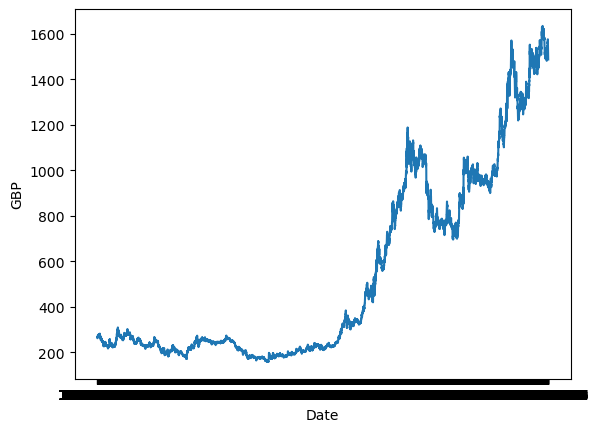

In [7]:
sns.lineplot(x = "Date", y = "GBP", data = df_day);

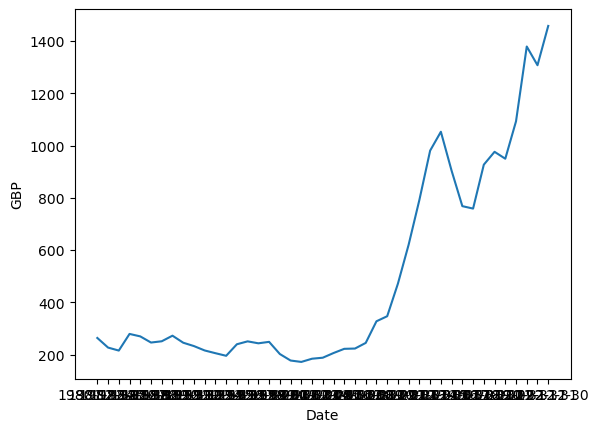

In [8]:
sns.lineplot(x = "Date", y = "GBP", data = df_ann);

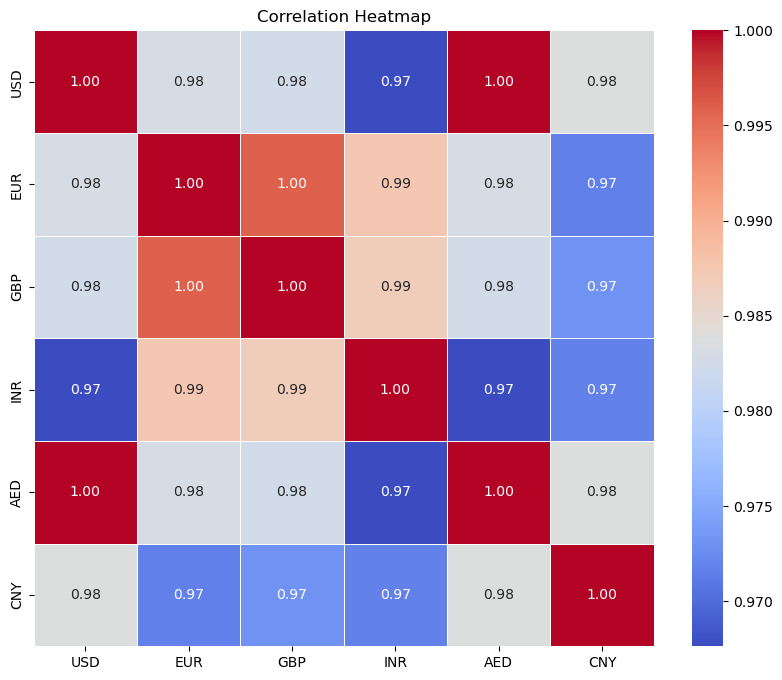

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


correlation_matrix = df_day.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()


## Import Data ##

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

df_lstm = pd.read_csv("daily_gold_rate.csv")
drop = ['EUR', 'USD','INR' , 'AED', 'CNY','Date']
df = df_lstm.drop(drop, axis = 1)

## Create LSTM model

### Create Dataloader

In [11]:
# Create dataloader
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

class GoldPriceDataset(Dataset):
    def __init__(self, dataframe, n_days):
        self.n_days = n_days
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.data = self.scaler.fit_transform(dataframe.iloc[:, 0].values.reshape(-1, 1)).flatten()

    def __len__(self):
        return len(self.data) - self.n_days

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.n_days]
        y = self.data[idx+self.n_days]
        return torch.from_numpy(x).float(), torch.tensor(y).float()


In [12]:
# Normal split
from torch.utils.data import Subset

dataset = GoldPriceDataset(df,30)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.9)
test_size = dataset_size - train_size

# Split train and test dataset
train_dataset = Subset(dataset, range(0, train_size))
test_dataset = Subset(dataset, range(train_size, dataset_size))

#Split train and validation dataset
train_size = len(train_dataset)
train_size2 = int(train_size * 0.9)
val_size = train_size - train_size2

train_dataset1 = Subset(train_dataset, range(0, train_size2))
val_dataset = Subset(train_dataset, range(train_size2, train_size))

# Create dataloader
train_loader = DataLoader(train_dataset1, batch_size=10, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

### LSTM model structure

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        
        self.out = nn.Sequential(nn.Linear(64,1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)
        out = self.out(r_out[:, -1, :])
        
        return out

### Training and Testing process

In [14]:
# set device function
def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

model = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

No GPU available! Running on CPU


In [15]:
# Training
best_loss = float('inf')
num_epochs = 50
for epoch in range(50):
    model.train()
    for tx, ty in train_loader: 
        output = model(torch.unsqueeze(tx, dim=2))
        loss = criterion(torch.squeeze(output), ty)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}')
        
        
    model.eval()
    for tx, ty in val_loader: 
        output = model(torch.unsqueeze(tx, dim=2))
        val_loss = criterion(torch.squeeze(output), ty)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss.item():.4f}')

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

Epoch [10/50], Training Loss: 0.0008
Epoch [10/50], Val Loss: 0.0001
Epoch [20/50], Training Loss: 0.0004
Epoch [20/50], Val Loss: 0.0002
Epoch [30/50], Training Loss: 0.0002
Epoch [30/50], Val Loss: 0.0004
Epoch [40/50], Training Loss: 0.0002
Epoch [40/50], Val Loss: 0.0007
Epoch [50/50], Training Loss: 0.0001
Epoch [50/50], Val Loss: 0.0008


In [16]:
# Testing
model = LSTM().to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))
y_pred_list = []
actual = []

model.eval()
for tx, ty in test_loader: 
    output = model(torch.unsqueeze(tx, dim=2))
    val_loss = criterion(torch.squeeze(output), ty)
    
    y_pred_list.append(output.tolist())
    actual.append(ty.tolist())

print(f'Test Loss: {val_loss.item():.4f}')

Test Loss: 0.0007


### Visualization on test dataset ###

### Scatter

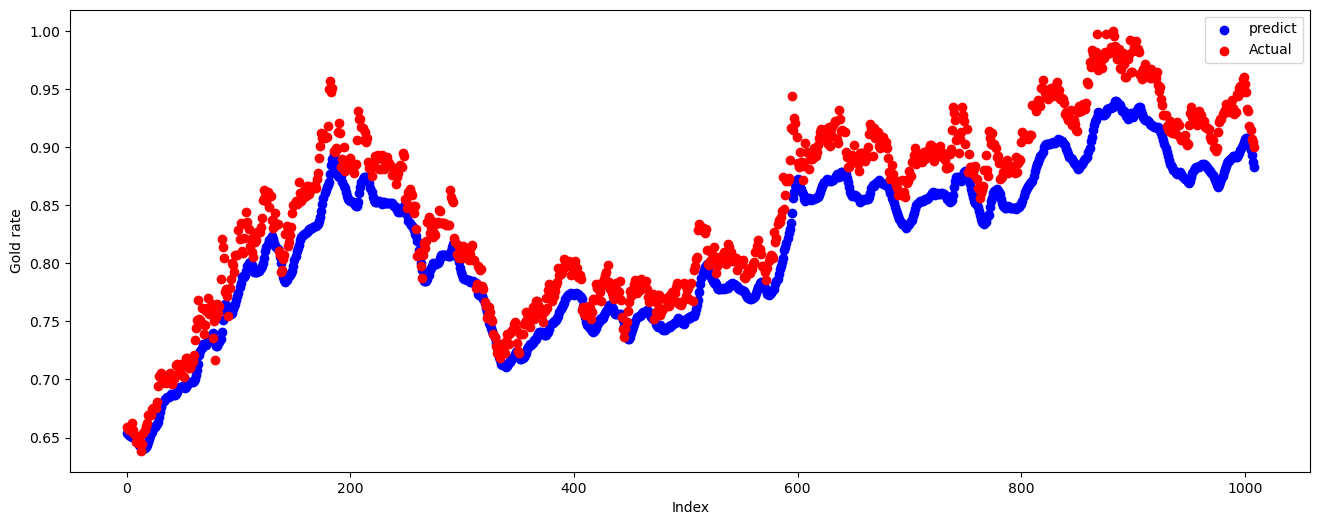

In [17]:
import matplotlib.pyplot as plt

# change the list structure
y_pred_list1 = [item for sublist in y_pred_list for item in sublist]
actual1 = [item for sublist in actual for item in sublist]


plt.figure(figsize=(16, 6))
plt.scatter(range(len(y_pred_list1)), y_pred_list1, color='blue', label='predict')
plt.scatter(range(len(actual1)),actual1, color='red', label='Actual')

plt.xlabel('Index')
plt.ylabel('Gold rate')
plt.legend()

plt.show()


### Visualization on all dataset ###

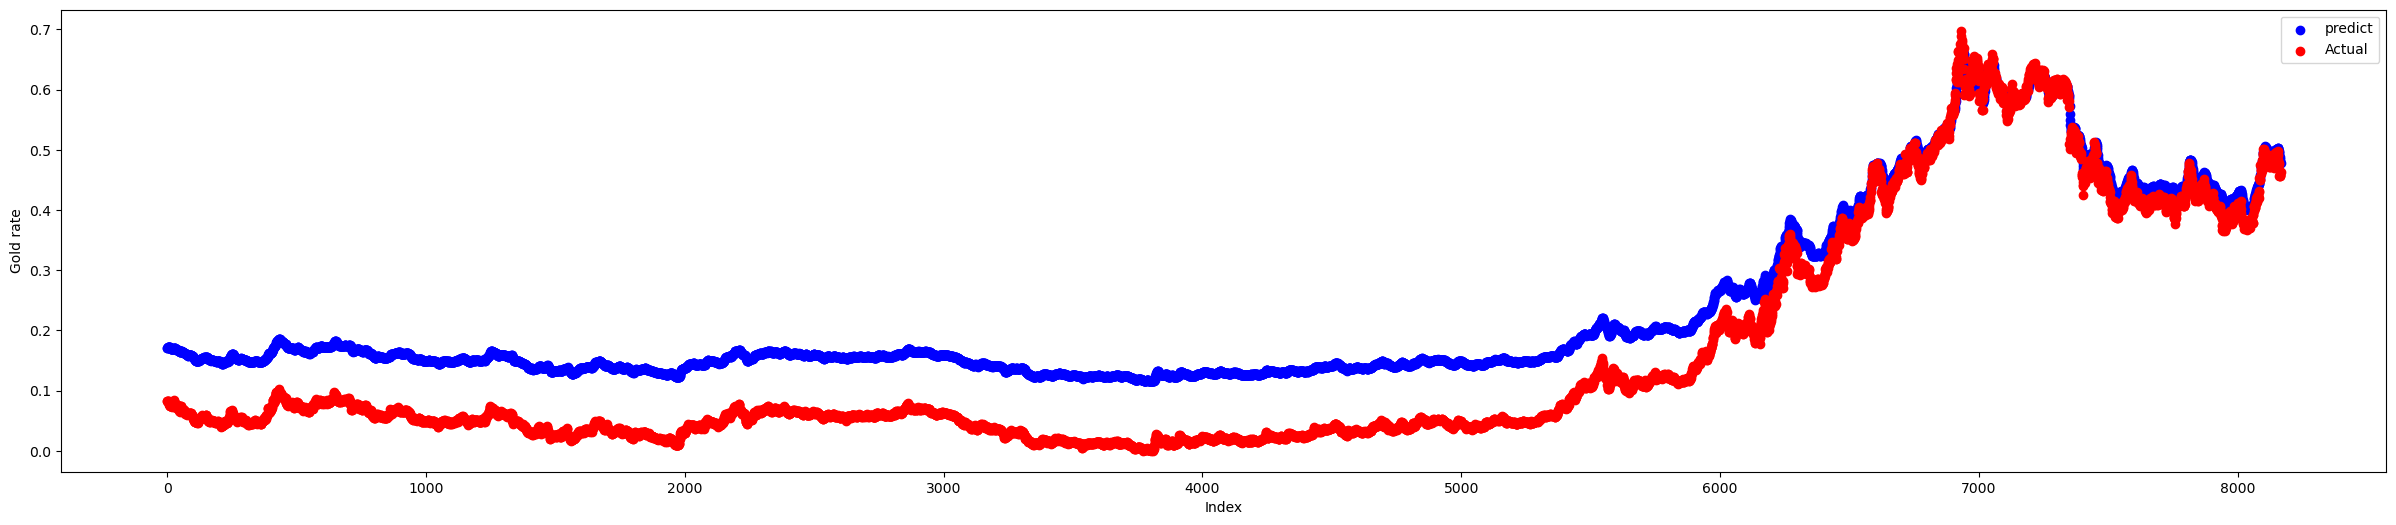

In [21]:
model = LSTM().to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))
y_pred_list = []
actual = []

model.eval()
for tx, ty in train_loader: 
    output = model(torch.unsqueeze(tx, dim=2))
    val_loss = criterion(torch.squeeze(output), ty)
    
    y_pred_list.append(output.tolist())
    actual.append(ty.tolist())



y_pred_list1 = [item for sublist in y_pred_list for item in sublist]
actual1 = [item for sublist in actual for item in sublist]


plt.figure(figsize=(30, 6))
plt.scatter(range(len(y_pred_list1)), y_pred_list1, color='blue', label='predict')
plt.scatter(range(len(actual1)),actual1, color='red', label='Actual')

plt.xlabel('Index')
plt.ylabel('Gold rate')
plt.legend()

plt.show()


## Interaction ##

In [22]:
# example:
# Input: datetime value = 2023-01-01
# Output: predicted gold price

def interaction_with_model(input_time, df_path, model, model_path):
    # get the model
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    
    # change the df to (0,1)
    df = pd.read_csv(df_path)
    drop = ['EUR', 'USD','INR' , 'AED', 'CNY']
    df = df.drop(drop, axis = 1).copy()
    min_price = df['GBP'].min()
    max_price = df['GBP'].max()
    df['normalized_price'] = (df['GBP'] - min_price) / (max_price - min_price)
    
    
    # use the day-time to get the previous 60 days gold price
    selected_prices = df[df['Date'] < input_time]['normalized_price'].tail(30).tolist()
    tensor_prices = torch.tensor(selected_prices)
    tensor_prices = tensor_prices.unsqueeze(0)

    
    # use the above prices to predict the day-time gold price
    output = model(torch.unsqueeze(tensor_prices, dim=2)).item()
    
    # denormalized_price
    output = (output * (max_price - min_price)) + min_price

    
    # return the predicted gold price
    return output

In [23]:
# 预测2019-10-15 到 2023-10-06之前的数据
model = LSTM()
day_time = '2020-01-17'
model_path = 'best_model.pth'
csv_path = "daily_gold_rate.csv"

a = interaction_with_model(day_time,csv_path, model, model_path)
print(f'Day time is  {day_time}, the predicted gold price is : {a}')

Day time is  2020-01-17, the predicted gold price is : 1169.5924996948243
